In [1]:
import astropy.io.fits as fits
import numpy as np
from numpy import array

from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy import stats

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck15
import treecorr


#import arviz as az
#import pandas as pd
import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample

%matplotlib inline

import halomod as hm
import hmf

import astropy.io.fits as pyfits
import copy
import sys

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [2]:
import package.subsample 
import package.subsample_analysis 
import package.correlation_function 
import package.cosmology
import package.bias_estimator
import package.bias_cal


In [3]:
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 


home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

In [4]:
config = {
    'min_sep':  0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'  # or 'jackknife'
}

In [5]:
w_thetas_SN_E2, w_theta_errors_SN_E2 = [], []

for i in range(21):

    data_SN_E2 = np.loadtxt(os.path.join(directory_SN_E2, f"SN_E2_{i}.txt"), comments='#')


    # Calculate sums for each subsample
    sum_dd_SN_E2 = data_SN_E2[:, 5]   
    sum_rr_SN_E2 = data_SN_E2[:, 6]
    sum_dr_SN_E2 = data_SN_E2[:, 7]
    
    w_theta_SN_E2 = (sum_dd_SN_E2 - 2 * sum_dr_SN_E2 + sum_rr_SN_E2) / sum_rr_SN_E2
    w_thetas_SN_E2.append(w_theta_SN_E2)
    
    
    # Error calculation for SN_E2
    fractional_error_SN_E2 = 1 / np.sqrt(sum_dd_SN_E2)
    errorbars_SN_E2 = fractional_error_SN_E2 * (w_theta_SN_E2 + 1)
    w_theta_errors_SN_E2.append(errorbars_SN_E2)


In [6]:
z_values = np.arange(0.3, 1.1, 0.1) 
theta = data_SN_E2[:, 1]
print(theta)

[0.0031496 0.0035157 0.0038613 0.0042923 0.0046872 0.0052279 0.0057686
 0.0063273 0.0069717 0.0077592 0.0085964 0.009459  0.010501  0.011552
 0.012762  0.014109  0.015653  0.017178  0.019063  0.021046  0.023245
 0.025652  0.028375  0.031369  0.034682  0.038257  0.042353  0.046737
 0.051626  0.057008  0.063032  0.069668  0.076917  0.084993  0.093922
 0.10384   0.11464   0.12674   0.14006   0.15475   0.17102   0.18886
 0.20861   0.2306    0.25477   0.28149   0.31114   0.34361   0.37974
 0.41949   0.46352   0.51214   0.56581   0.62515   0.69094   0.76312
 0.84318   0.93156   1.0286    1.1357    1.2544    1.381     1.5249
 1.6799   ]


Subsample 1:


/tmp/ipykernel_1889695/535980708.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


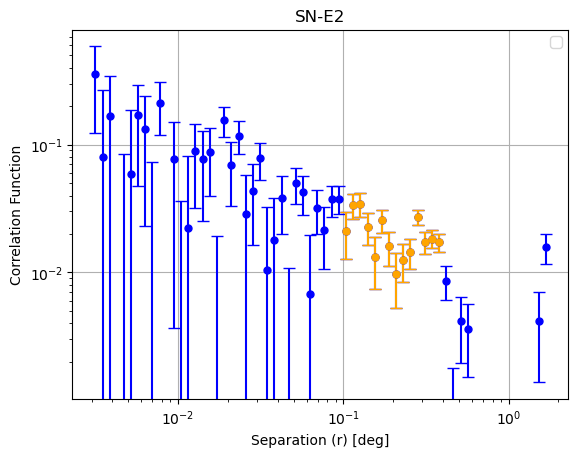

Subsample 2:


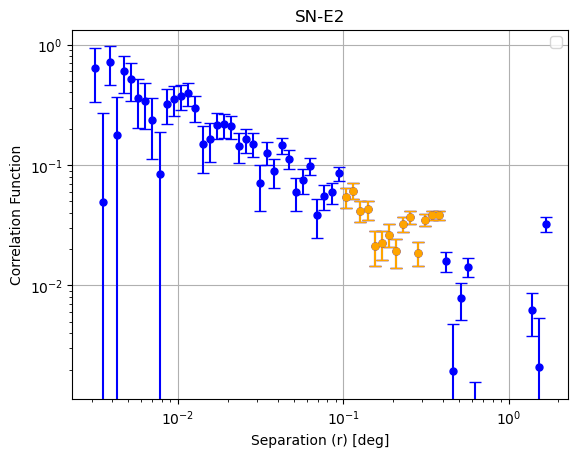

Subsample 3:


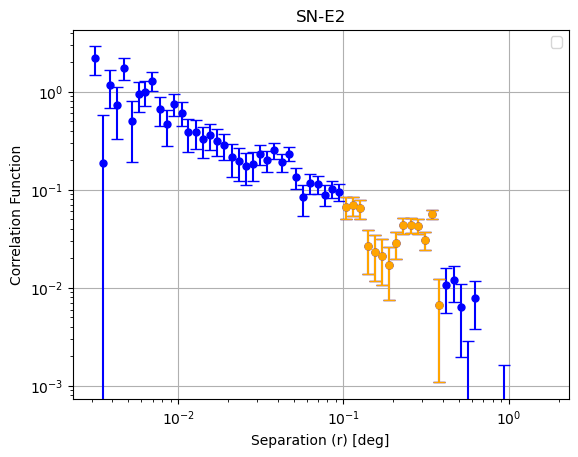

Subsample 4:


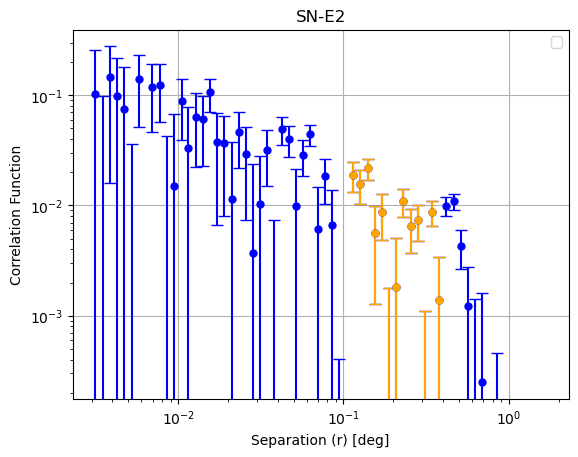

Subsample 5:


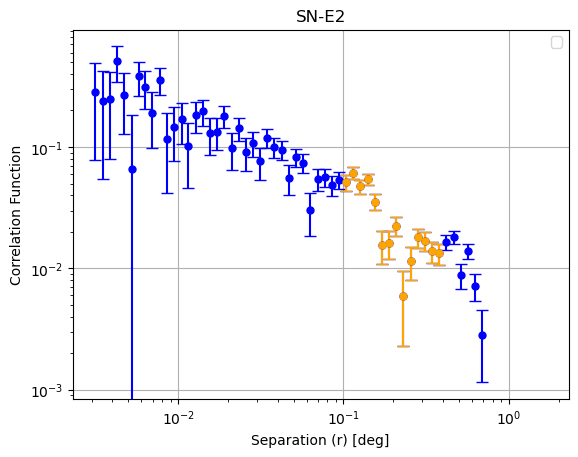

Subsample 6:


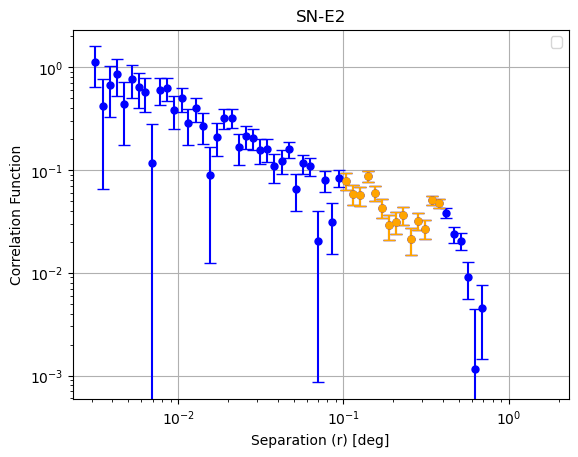

Subsample 7:


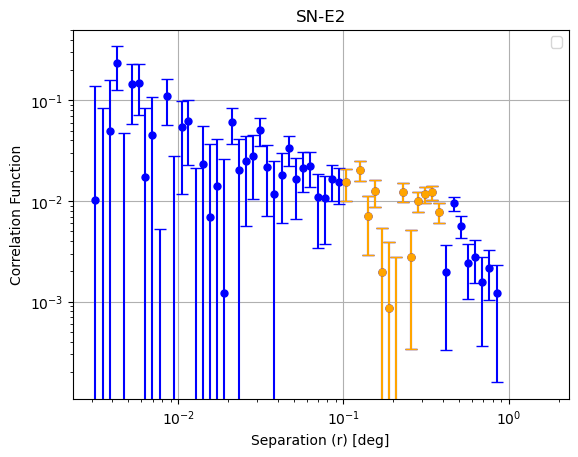

Subsample 8:


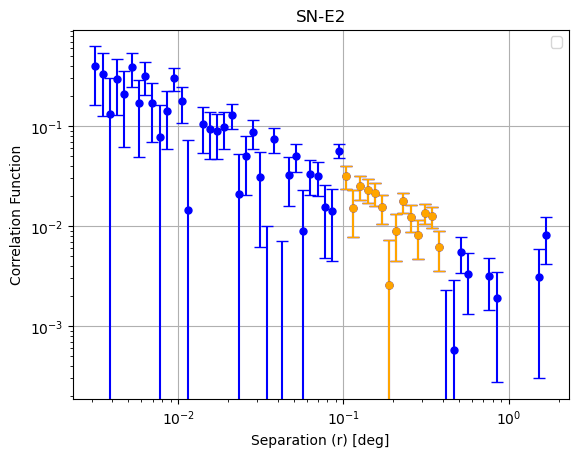

Subsample 9:


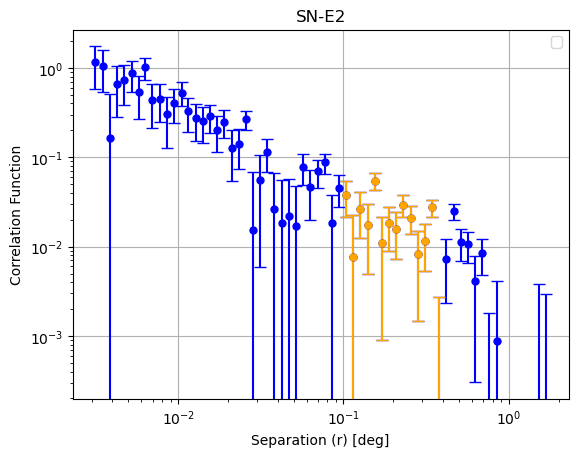

Subsample 10:


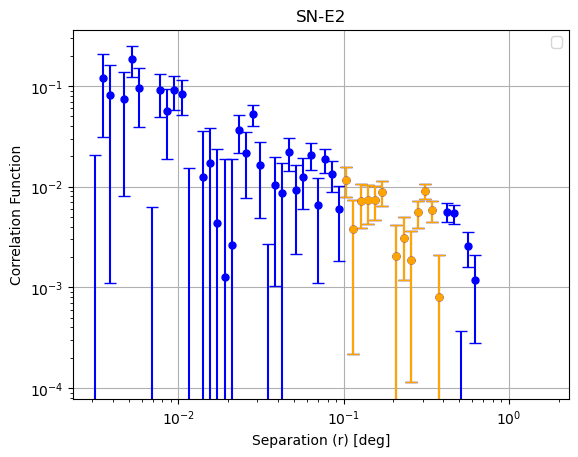

Subsample 11:


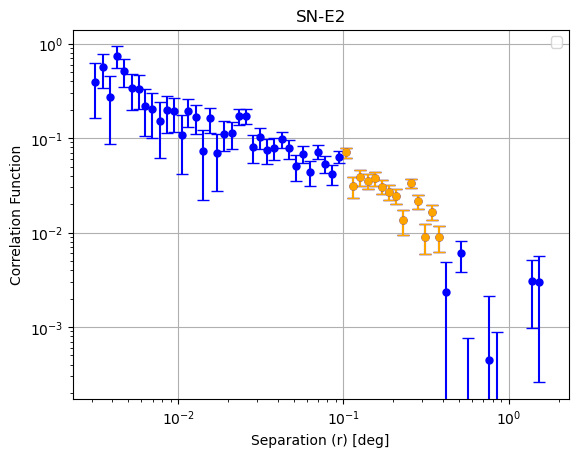

Subsample 12:


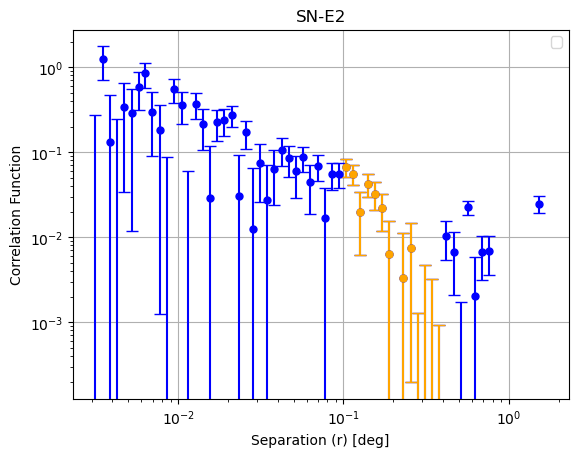

Subsample 13:


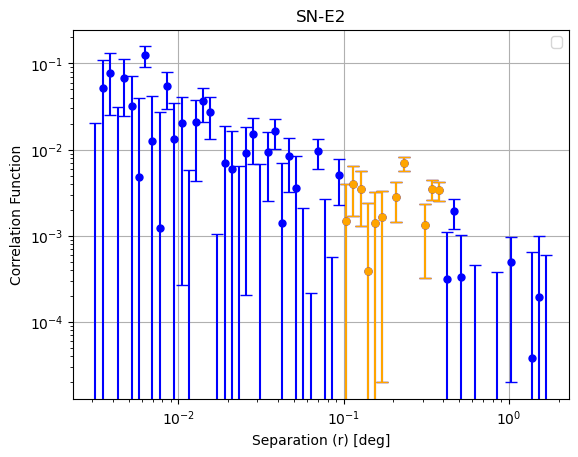

Subsample 14:


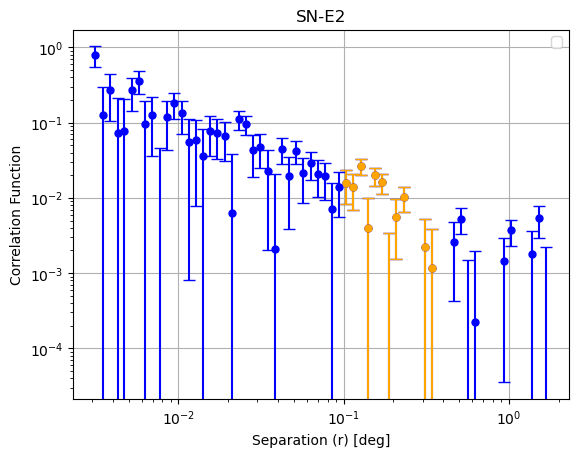

Subsample 15:


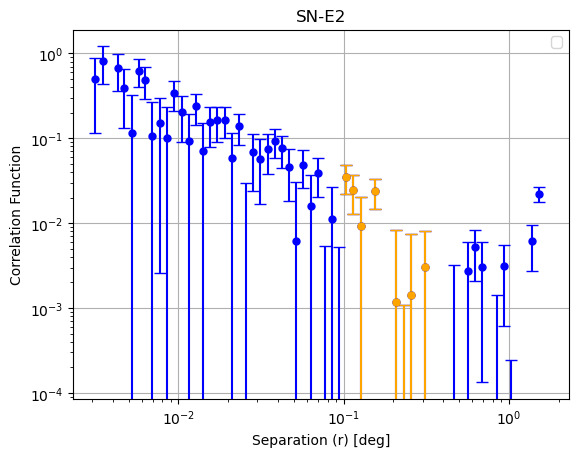

Subsample 16:


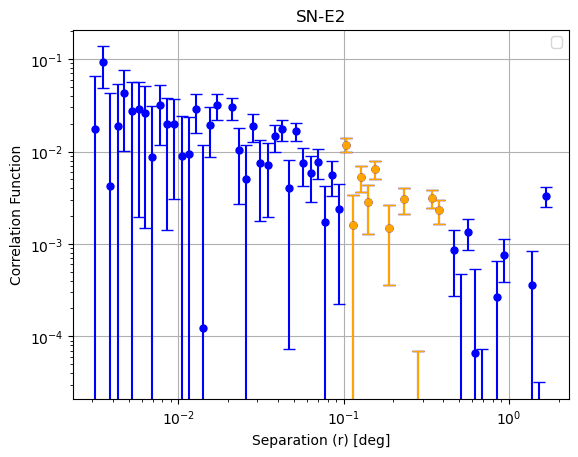

Subsample 17:


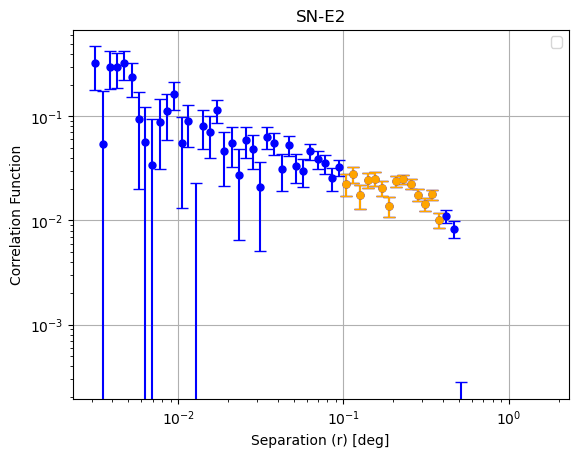

Subsample 18:


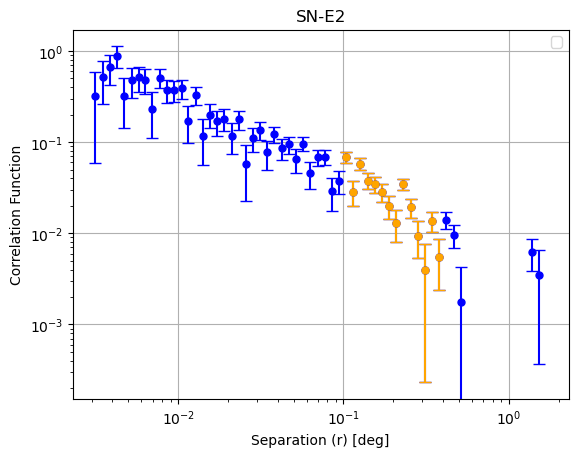

Subsample 19:


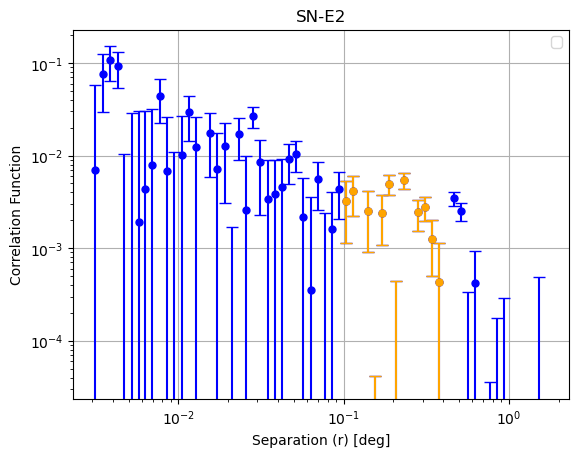

Subsample 20:


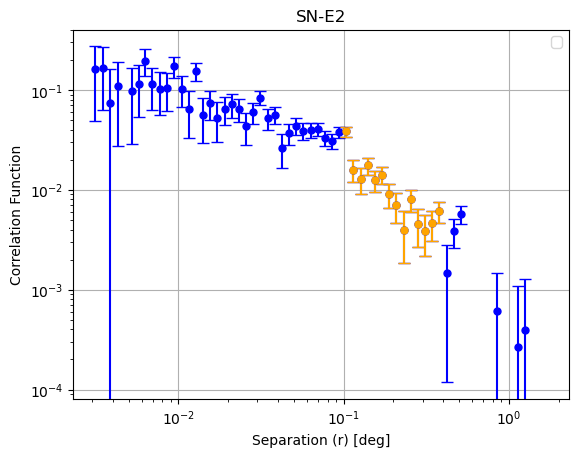

Subsample 21:


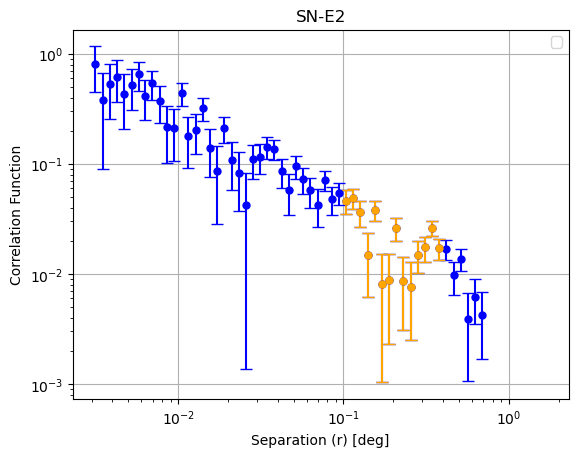

In [7]:
mask = (theta >= 0.1) & (theta <= 0.4)

for i in range(21): 
    print(f"Subsample {i+1}:")
    #print(w_thetas_SN_E2[i])

    plt.errorbar(theta, w_thetas_SN_E2[i], yerr=w_theta_errors_SN_E2[i],fmt='o', color='blue', capsize=4, markersize=5)
    plt.errorbar(theta[mask], w_thetas_SN_E2[i][mask],yerr=w_theta_errors_SN_E2[i][mask],  fmt='o', color='orange',capsize=4, markersize=5)  # 2 halo term

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Separation (r) [deg]')
    plt.ylabel('Correlation Function')
    plt.legend()
    plt.title('SN-E2')
    plt.grid(True)
    plt.show()


In [8]:
nz = hm.integrate_corr.flat_z_dist(np.min(z_values), np.max(z_values))
gg = hm.integrate_corr.AngularCF(nz,nz,theta_min= np.min(theta[mask])*np.pi/180 ,theta_max=np.max(theta[mask])*np.pi/180 ,theta_num = len(theta),zmin=np.min(z_values),zmax=np.max(z_values),z=np.mean(z_values),p_of_z=True)
gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}



/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


In [9]:
    
# Define z and SM ranges
z_values = np.arange(0.3, 1.1, 0.1)  ### be careful about completness issues, maybe stop at 0.4 for high SM

#SM_range = np.linspace(9.5, 11, num=2) # High SM
#SM_range = np.linspace(8, 9.5, num=2) #Low SM
SM_range = np.linspace(8, 11, num=4) # diff SM



# Create subsamples
subsamples = []
z_mean_range = []
SM_mean_range = []

for i in range(len(z_values) - 1):
    z_min = z_values[i]
    z_max = z_values[i + 1]
    z_mean = (z_min + z_max) / 2
    z_mean_range.append(z_mean)

    for j in range(len(SM_range) - 1):
        SM_min = SM_range[j]
        SM_max = SM_range[j + 1]
        SM_mean = (SM_min + SM_max) / 2
        SM_mean_range.append(SM_mean)

        subsample = package.subsample.Subsample(z_min, z_max, SM_min, SM_max)
        
        subsample.info['z_mean'] = z_mean  # Add z_mean to the info dictionary
        subsample.info['z_min'] = z_min 
        subsample.info['SM_mean'] = SM_mean  # Add SM_mean to the info dictionary
        subsample.info['delta_z'] = (z_max - z_min)  # Assuming delta_z is the redshift bin width
        subsamples.append(subsample)


In [10]:

mask = (theta >= 0.1) & (theta <= 0.4)  # to get only the 2-halo term
for i in range(21): 
    samp=package.subsample.Subsample
    gg = hm.integrate_corr.AngularCF(samp.nz, samp.nz,theta_min= np.min(theta[mask])*np.pi/180 ,theta_max=np.max(theta[mask])*np.pi/180 ,theta_num = len(theta),zmin=np.min(z_values),zmax=np.max(z_values),z=np.mean(z_values),p_of_z=True)
    gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}

   

    bias_estimator = package.bias_cal.BiasEstimator(gg, w_thetas_SN_E2[i], w_theta_errors_SN_E2[i], sum_rr_SN_E2[i], mask)
    b, be = bias_estimator.estimate_bias()
    print(bias_estimator.IC_list)

AttributeError: type object 'Subsample' has no attribute 'nz'

In [ ]:
nz = hm.integrate_corr.flat_z_dist(np.min(z_values), np.max(z_values))
gg = hm.integrate_corr.AngularCF(nz,nz,theta_min= np.min(theta)*np.pi/180 ,theta_max=np.max(theta)*np.pi/180 ,theta_num = len(theta),zmin=np.min(z_values),zmax=np.max(z_values),z=np.mean(z_values),p_of_z=True)
gg.hod_params = {"M_min":13.27, "M_1": 14.6, "alpha":1.}

In [ ]:
mask = (theta >= 0.1) & (theta <= 0.4)

for i in range(21): 
    print(f"Subsample {i+1}:")
    #print(w_thetas_SN_E2[i])

    plt.errorbar(theta, w_thetas_SN_E2[i], yerr=w_theta_errors_SN_E2[i],fmt='o', color='blue', capsize=4, markersize=5)
    plt.errorbar(theta[mask], w_thetas_SN_E2[i][mask],yerr=w_theta_errors_SN_E2[i][mask],  fmt='o', color='orange',capsize=4, markersize=5)  # 2 halo term
    
    plt.loglog(theta, gg.angular_corr_gal, label=r'$\xi_g(r)$', color='r')
    plt.loglog(theta, gg.angular_corr_matter, label=r'$\xi_m(r)$', color='k')
    #plt.loglog(theta, gg.angular_corr_matter*biases[i]**2 -IC, label=r'Model', color='g')

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Separation (r) [deg]')
    plt.ylabel('Correlation Function')
    plt.legend()
    plt.title('SN-E2')
    plt.grid(True)
    plt.show()
